In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [3]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
# Set the directories containing the images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [6]:
image_x = random.randint(0, 300)
image_x

42

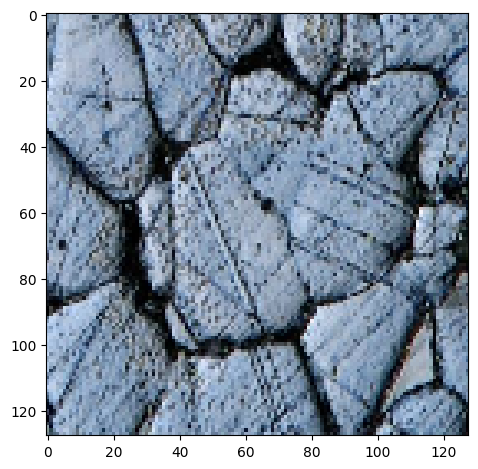

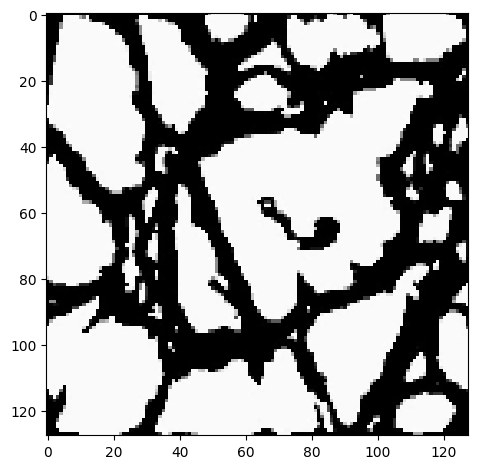

In [7]:
# example
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

In [8]:
###############################
import os
from datetime import datetime
# create the checkpoint path
checkpoint_dir = '/content/checkpoint_path'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_file = f'GrainsTraining_{timestamp}.pt'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom dataset
class GrainDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)

        return image, mask

# Load data
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

images = []
masks = []

for file in sorted(os.listdir(image_dir)):
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, (128, 128))
    images.append(img)

for file in sorted(os.listdir(mask_dir)):
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, (128, 128))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert to single channel
    masks.append(mask)

X_train = np.array(images)
Y_train = np.array(masks)

# Prepare data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = GrainDataset(images=X_train, masks=Y_train, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class ResNet50Segmentation(nn.Module):
    def __init__(self):
        super(ResNet50Segmentation, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # Modify the final layer to match your output dimensions and include a Sigmoid activation
        self.resnet50.fc = nn.Sequential(
            nn.Linear(self.resnet50.fc.in_features, 128*128),  # Adjust for your output size
            nn.Sigmoid(),  # Ensure output is in [0,1]
        )

    def forward(self, x):
        x = self.resnet50(x)
        x = x.view(-1, 1, 128, 128)  # Reshape to match the mask shape
        return x

model = ResNet50Segmentation().to(device)

criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters())

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/GrainsTraining{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1) / 255.0  # Normalize targets to [0, 1] and ensure correct shape

        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure outputs are in the correct range [0, 1],
        # model should ideally end with a sigmoid activation for BCELoss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1) / 255.0  # Normalize targets

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model, epoch, train_loss, val_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Epoch [1/20], Train Loss: 0.6867, Val Loss: 0.9759
Checkpoint saved
Epoch [2/20], Train Loss: 0.6712, Val Loss: 0.9175
Checkpoint saved
Epoch [3/20], Train Loss: 0.6705, Val Loss: 0.6829
Checkpoint saved
Epoch [4/20], Train Loss: 0.6708, Val Loss: 1.0798
Epoch [5/20], Train Loss: 0.6703, Val Loss: 4.2860
Epoch [6/20], Train Loss: 0.6681, Val Loss: 0.6840
Epoch [7/20], Train Loss: 0.6657, Val Loss: 0.6831
Epoch [8/20], Train Loss: 0.6620, Val Loss: 1.1542
Epoch [9/20], Train Loss: 0.6617, Val Loss: 0.7485
Epoch [10/20], Train Loss: 0.6605, Val Loss: 0.6713
Checkpoint saved
Epoch [11/20], Train Loss: 0.6591, Val Loss: 0.6744
Epoch [12/20], Train Loss: 0.6574, Val Loss: 0.6725
Epoch [13/20], Train Loss: 0.6566, Val Loss: 0.6707
Checkpoint saved
Epoch [14/20], Train Loss: 0.6545, Val Loss: 0.6748
Epoch [15/20], Train Loss: 0.6545, Val Loss: 0.6733
Epoch [16/20], Train Loss: 0.6521, Val Loss: 0.6722
Epoch [17/20], Train Loss: 0.6504, Val Loss: 0.6707
Epoch [18/20], Train Loss: 0.6507, Val L

In [10]:
import pandas as pd
import torch

# Load the saved model checkpoint
checkpoint_path = '/content/drive/MyDrive/465 project demo 1/Fewshot Ckpts/GrainsTraining30032024 21_03_59.pt'  # Adjust this path accordingly
checkpoint = torch.load(checkpoint_path)
# print(checkpoint.keys())

# Extract specific information from the checkpoint
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

# Create a DataFrame for the training and validation loss
loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
loss_df = pd.DataFrame(loss_data)

# Print the DataFrame in Markdown table format
print(loss_df.to_markdown(index=False))


|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|       4 |        0.667089 |          0.672753 |


In [11]:
# Set model to evaluation mode
model.eval()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))
print(f"Input data type: {X_train.dtype}")

# Perform predictions on training and validation data
with torch.no_grad():
    # Convert input data to torch tensor and move to the appropriate device (e.g., GPU)
    input_train_tensor = torch.tensor(X_train[:int(X_train.shape[0]*0.9)], dtype=torch.float32).permute(0, 3, 1, 2).cuda()
    input_val_tensor = torch.tensor(X_train[int(X_train.shape[0]*0.9):], dtype=torch.float32).permute(0, 3, 1, 2).cuda()

    # Perform predictions
    preds_train_tensor = model(input_train_tensor)
    preds_val_tensor = model(input_val_tensor)

# Convert predictions to numpy arrays and apply thresholding
preds_train_np = (preds_train_tensor.cpu().numpy() > 0.5).astype(np.uint8)
preds_val_np = (preds_val_tensor.cpu().numpy() > 0.5).astype(np.uint8)

Input data type: uint8


In [14]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [28]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

ValueError: If `preds` and `target` are of shape (N, ...) and `preds` are floats, `target` should be binary.